In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.stats import gamma
import random
from copy import deepcopy
import tqdm

## Combinatorial problem formulations and QUBO funcs

###  Number partition problem 

Given a set $S$ of $N$ positive numbers 
$S = \{ n_{0}, \ldots , n_{N-1}\}$, is there a partition of $S$ into $P$ disjoint subsets $\{ R_0, \ldots , R_{P-1} \}$, such that the sum of values in 
each set is the same. I.e., can a set of $N$ assets with values $n_0, \ldots , n_{N-1}$ fairly be distributed between $P$ parties?

The Quadratic Unconstrained Binary Optimization model can be formulated in the following way

\begin{align}
	H = \sum_{p=0}^{P-1}  \left( \sum_{i=0}^{N-1} n_{i} x_{i, p} - \frac{1}{P} \sum_{i=0}^{N-1} n_{i} \right)^2 + M \sum_{i=0}^{N-1}  \left( 1- \sum_{p=0}^{P-1} x_{i, p} \right)^2 \, ,
\end{align}

and the decision variable $x_{i, p} \in \{0,1\}$ is defined as

\begin{align}
	x_{i, p} = 
    \begin{cases}
	1 & \text{if number } n_i \text{ of set } S \text{ is in set } R_p \\
	0 & \text{else}
    \end{cases} \, .
\end{align}

- $P=4$: Number of subsets.
- $N$: Number of values in set $S$.
- ${\rm{bits}} = N \cdot P$: Number of bits needed to represent problem QUBO.
- $M$: Penalty factor.

Expanding the Hamiltonians $H = H_o + M H_p$:


$$
H_o = P\alpha^2 + \sum_{i,p} (n_i^2 - 2\alpha n_i) x_{ip} + \sum_{p, i \ne i^{'}} n_i n_{i^{'}} x_{ip} x_{i^{'}p}
$$
where $\alpha = \sum_i n_i/P$.

$$
H_p = N - \sum_{i,p} x_{ip} + \sum_{i, p \ne p^{'}} x_{ip} x_{ip^{'}}
$$
### Traveling salesman problem

Given a graph $G=(V,E)$ with $N=|V|$ nodes (cities), what is the cheapest hamiltonian cycle, considering the edge $e_{i,j}$ as the cost from going from city $i$ to city $j$?

The Quadratic Unconstrained Binary Optimization model can be formulated in the following way

\begin{align}
	H = \sum_{t=1}^{N}   \sum_{i\ne j=1}^{N} e_{i,j} x_{t, i}x_{t+1, j}  + M \bigg[ \sum_{i=1}^{N}  \left( 1- \sum_{t=1}^{N} x_{t, i} \right)^2 + \sum_{t=1}^{N}  \left( 1- \sum_{i=1}^{N} x_{t, i} \right)^2  \bigg]\, ,
\end{align}

and the decision variable $\{x_{t, i}\}_{i,t=1,\dots,N} \in \{0,1\}^{N^2}$ is defined as

\begin{align}
	x_{t, i} = 
    \begin{cases}
	1 & \text{if city } i \text{ is visited at time step } t \\
	0 & \text{else}
    \end{cases} \, .
\end{align}

The constraint enforces the decision matrix $[x]_{t, i}$ to be a permutation matrix, ordering the temporal visit of each city.

- $N$: Number of cities/nodes.
- ${\rm{bits}} = N^2$: Number of bits needed to represent problem QUBO.
- $M$: Penalty factor.


Expanding the Hamiltonians $H = H_o + M H_p$:

$$
H_o = \sum_{t=1}^{N}   \sum_{i\ne j=1}^{N} e_{i,j} x_{t, i}x_{t+1, j}
$$

$$
H_p = 2N - 2\sum_{t,i}^{N} x_{ti} + \sum_{t,i}^{N} \biggl( \sum_{i^{'} \ne i}^{N} x_{ti} x_{ti^{'}} + \sum_{t^{'} \ne t}^{N} x_{ti} x_{t^{'}i} \biggr)
$$
where $N = N_{cities}$.



### Portfolio Optimization

Given $N$ stocks and a fixed bugdet to spend, what are the portions of the budget to assign to each stock to maximise return $\mu$ while minimizing the risk $\Sigma$? The granularity is a parameter $w$.

The Quadratic Unconstrained INTEGER Optimization model can be formulated in the following way

\begin{align}
	H = \sum_{i, j=1}^{N} (\gamma  \Sigma_{i,j} - \delta_{ij}\mu_{i}) \tilde x_{i} \tilde x_{j}  + M \bigg[ \sum_{i=1}^{N} \tilde x_i - (2^w - 1)  \bigg]^2\, ,
\end{align}

where $\gamma$ is the risk aversion factor, the decision variable $\tilde x \in \{0, \cdots, 2^w-1\}^N$ is a vector of integers, one for each stock, that indicates how many equal portions of the $2^w-1$ to invest in each stock. The constraint enforces that the total portions of the stocks sum up to $2^w - 1$.

In order to be mapped to a binary problem, each integer variable $\tilde x_i \in \{0, \cdots, 2^w-1\}$ can be expressed using $w$ bits via: $\tilde x_i = \sum_{k = 0}^{w-1} 2^k x^{(i)}_k$.

In the QUBO reformulation, if we want to keep just the binary variables as bits while incorporating the powers of $2$ in the problem matrix, we can rewrite them in the following way. Only for the return $\mu$ will be showed for semplicity: we want to go from $\mu_{(int)} \in \mathbb R ^N \to \mu_{(bin)} \in \mathbb R ^{wN}$. First we repeat $w$ times each entry of $\mu_{(int)}$, then we entry-wise multiply it by the scaler $A = N \textit{ times }[2^{w-1}, 2^{w-2}, \cdots, 2^1, 2^0]$, to get in the end $\mu_{(bin)} = [2^{w-1} \mu_{(int)}[0], 2^{w-2} \mu_{(int)}[0], \cdots, 2^0 \mu_{(int)}[0], 2^{w-1} \mu_{(int)}[1], \cdots, \cdots, 2^{0} \mu_{(int)}[N-1]]$.


- $N$: Number of stocks.
- $w$: Granularity: each ratio can be described to a precision of $(2^w-1)^{-1}$, and you need $w$ qubits per stock
- ${\rm{bits}} = Nw*$: Number of bits needed to represent problem QUBO.
- $M$: Penalty factor.


Expanding the Hamiltonians $H = H_o + M H_p$, using now BINARY variables, the Quadratic Unconstrained Binary Optimization model can be formulated in the following way, where $A_{(bin)} \in \mathbb N ^{wN}, \;\mu_{(bin)} \in \mathbb R ^{wN}, \; \Sigma_{(bin)} \in \mathbb R ^{wN \times wN}$ and we characterized the constraints elements $A_{(bin)i} = 2^{w - 1 - i\%w}$, $b = 2^w - 1$, so that the constraint can be expressed as $Ax = b$.

$$
H_o =  \sum_{i, j=1}^{Nw}  (\gamma  \Sigma_{(bin)i,j} - \delta_{ij}\mu_{(bin)i}) x_{i}x_{j}
$$

$$
H_p = \bigg[ \sum_{i=1}^{N} \tilde x_i - b  \bigg]^2 = b^2 + \sum_{i}^{Nw} \biggl(-2 b A_{(bin)i} \biggr)x_{i} + \sum_{i, j}^{Nw} A_{(bin)i} A_{(bin)j} x_i x_j
$$


In [2]:
### QUBO FUNCTIONS

def L1_norm(Q, const):
    return const + np.sum(np.abs(Q))

def L1_norm_hot(Q, const, n_bits, temperature, max_prob_inf):
    return L1_norm(Q, const) + temperature*(n_bits*np.log(2) - np.log(max_prob_inf))

def build_numbs_set(N, P, seed):
    random.seed(seed)
    numbs = [int(1000*random.uniform(0.0, 1.0)) for _ in range(N)]
    total = sum(numbs)
    if numbs[-1] - (total % P) > 1:
        numbs[-1] -= (total % P)
    else:
        numbs[-1] += (P - (total % P))
    total = sum(numbs)
    return numbs

def idx_onehot(i, p, P):
    return i*P + p

def symmetrize(Q):
    return (Q + Q.T)/2



#### NPP specific



def build_obj_NPP(numbs, N, P):
    H = np.zeros((N*P, N*P))
    alpha = np.sum(numbs)/P

    for p in range(P):
        for i in range(N):
            H[idx_onehot(i, p, P), idx_onehot(i, p, P)] = numbs[i]**2 - 2*alpha*numbs[i]
            for i_prime in range(N):
                if i_prime == i:
                    continue
                H[idx_onehot(i, p, P), idx_onehot(i_prime, p, P)] = numbs[i] * numbs[i_prime]
    const = P*alpha**2
    H = symmetrize(H)
    return H, const

def build_pen_NPP(N, P):
    H = np.zeros((N*P, N*P))
    for p in range(P):
        for i in range(N):
            H[idx_onehot(i, p, P), idx_onehot(i, p, P)] = -1
            for p_prime in range(P):
                if p_prime == p:
                    continue
                H[idx_onehot(i, p, P), idx_onehot(i, p_prime, P)] = 1
    const = N
    H = symmetrize(H)
    return H, const

def get_QUBO_NPP(N, P, M, seed, objective = True, penalization=True):
    ''' build a NPP QUBO with N integers, P partitions, M penalty factor, for problem identified with seed '''
    Q, const = np.zeros((N*P, N*P)), 0
    if objective:
        numbs = build_numbs_set(N, P, seed)
        Ho, const_o = build_obj_NPP(numbs, N, P)
        Q += Ho
        const += const_o
    if penalization:
        Hp, const_p = build_pen_NPP(N, P)
        Q += M*Hp
        const += M*const_p
    return Q, const



# TSP specific



def build_adjacency(Nc, seed, circle_flag):
    if circle_flag:
        # trivial construction of adj. matrix of graph with N cities on a circle. Modify this function to get more complex structures
        coordinates = [(1_000_000 * np.cos((index / Nc) * 2 * np.pi), 1_000_000 * np.sin((index / Nc) * 2 * np.pi)) for index in range(Nc)]
        distance_table = [[int(np.sqrt((coordinates[c_1][0] - coordinates[c_0][0]) ** 2 + (coordinates[c_1][1] - coordinates[c_0][1]) ** 2)) for c_0 in range(Nc)] for c_1 in range(Nc)]
    else:
        # random construction of the adjacency matrix, based on euclidian distance. (cities are uniformly randomly placed inside a square)
        np.random.seed(seed)
        coordinates = 1e6 * np.array( [np.random.uniform(low = -1, high = 1, size = 2) for i in range(Nc)] )
        distance_table = [[int(np.sqrt((coordinates[c_1][0] - coordinates[c_0][0]) ** 2 + (coordinates[c_1][1] - coordinates[c_0][1]) ** 2)) for c_0 in range(Nc)] for c_1 in range(Nc)]
    return np.array(distance_table)

def build_obj_TSP(distances, Nc):
    H = np.zeros((Nc**2, Nc**2))
    for t in range(Nc):
        for i in range(Nc):
            for i_prime in range(Nc):
                if i_prime != i:
                    H[idx_onehot(t, i, Nc), idx_onehot((t+1)%Nc, i_prime, Nc)] = distances[i, i_prime]
    H = symmetrize(H)
    const = 0
    return H, const

def build_pen_TSP(Nc):
    H = np.zeros((Nc**2, Nc**2))
    for t in range(Nc):
        for i in range(Nc):
            H[idx_onehot(t, i, Nc), idx_onehot(t, i, Nc)] = -2
            for i_prime in range(Nc):
                if i_prime != i:
                    H[idx_onehot(t, i, Nc), idx_onehot(t, i_prime, Nc)] += 1
            for t_prime in range(Nc):
                if t_prime != t:
                    H[idx_onehot(t, i, Nc), idx_onehot(t_prime, i, Nc)] += 1
    const = 2*Nc
    H = symmetrize(H)
    return H, const

def get_QUBO_TSP(Nc, M, seed, circle_flag = False, objective = True, penalization=True):
    ''' build a TSP QUBO with Nc cities, M penalty factor, for problem identified with seed '''
    Q, const = np.zeros((Nc**2, Nc**2)), 0
    if objective:
        distances = build_adjacency(Nc, seed, circle_flag)
        Ho, const_o = build_obj_TSP(distances, Nc)
        Q += Ho
        const += const_o
    if penalization:
        Hp, const_p = build_pen_TSP(Nc)
        Q += M*Hp
        const += M*const_p
    return Q, const



# PO specific



def build_risk_return(N, w, seed, multiplier = 1e4, risk_aversion = 1, var_norm = True):
    ''' Build some random return and risk matrix. notice: just random number. TODO: implement real stocks prediction as data '''
    np.random.seed(seed)
    mu = np.random.rand(N)*multiplier
    sigma = np.random.rand(N, N)*multiplier * risk_aversion # use risk_adversion factor to weight the risk wrt the return
    sigma = symmetrize(sigma) # this line is only to simulate this is a variance matrix. later, this will be discarded as sigma dn run will really be return and risk, not just random numbers
    # if variables are desired to be normalized, divide Sigma and Mu by normalization factors
    if var_norm:
        mu = mu / (2**w - 1)
        sigma = sigma / (2**w - 1)**2
    return mu, sigma

def build_obj_PO(N, w, mu, sigma):
    ''' return quadratic part and constant part of the objective part of the hamiltonian.
    Note that the return mu and risk sigma already incorporate multiplier, risk aversion and the variables normalization.
    Note that the return mu and risk sigma are in the integer formulation, they need to be brought to binary formualtion. '''

    # get binary formulation (mu and sigma are now in integer formulation)
    assert len(mu) == N
    n_bin = N * w
    scaler = np.array( [2**i for i in range(w-1, -1, -1)]*N )
    Mu = np.array([[el for i in range(w)] for el in mu]).flatten()
    Mu = Mu*scaler
    grid = np.outer(scaler, scaler)
    Sigma = np.kron(sigma, np.ones((w, w)))
    Sigma = Sigma*grid
    assert len(Mu) == n_bin
    assert np.shape(Sigma)[0] == N * w

    H = - np.diag(Mu) + Sigma # risk aversion is already included in Sigma
    const = 0
    print("Never checked if it's correct. If you see this message, first check correctness of H_o, const_o")
    return H, const

def build_pen_PO(N, w):
    ''' return quadratic part and constant part of the penalization part of the hamiltonian '''
    # constraints in the formulation      Ax = b 
    A = np.array( [2**i for i in range(w-1, -1, -1)]*N )
    b = 2**w - 1
    # build [H, const] from [A, b]. easier formulation since b is scalar and A only 1 row, since there's only 1 constraint.
    H = np.outer(A, A)
    H -= 2*b*np.diag(A)
    const = b**2
    return H, const

def get_QUBO_PO(N, w, M, seed, objective = True, penalization=True):
    ''' build a PO QUBO with N stocks, w qubits per stock, M penalty factor, for problem identified with seed '''
    Q, const = np.zeros(((N*w), (N*w))), 0
    if objective:
        mu, sigma = build_risk_return(N, w, seed)
        Ho, const_o = build_obj_PO(N, w, mu, sigma)
        Q += Ho
        const += const_o
    if penalization:
        Hp, const_p = build_pen_PO(N, w)
        Q += M*Hp
        const += M*const_p
    return Q, const


### Generally useful functions


def nearest_to(ref_array, element):
    """
    Given a requested element (e.g. energy), returns the nearest value in a reference array, together with its position in the array
    """
    diff = np.abs(ref_array - element)
    idx = np.argmin(diff)
    return idx, ref_array[idx]

def remove_outliers(l, whisker_len = 1.5):
    q1, q3 = np.percentile(l, [25, 75])
    thres = q3 + whisker_len*(q3-q1)
    l = np.delete(l, l > thres)
    return l, thres

## Random sampling and Gibbs sampling

In [3]:
### Random Sampling functions

def evaluate_energy(solution, Q, const):
    return const + np.dot(solution, np.dot(Q, solution))

def sample_sol(n_bits):
    return np.random.randint(0, 2, size = n_bits)

def RandomSampler(Q, const, n_bits, n_sample):
    Es = np.ndarray((n_sample))
    for j in range(n_sample):
        x = sample_sol(n_bits)
        Es[j] = evaluate_energy(x, Q, const)
    return Es

def SpectralDistribution(Q, const, n_bits):
    ener = np.array([ evaluate_energy(state_inttobin(i, n_bits), Q, const) for i in range(2**n_bits)])
    return ener

def RandomSampler_Feasible_NPP(N, P, seed, n_sample):
    numbs = np.array(build_numbs_set(N, P, seed))
    Es = np.ndarray((n_sample))
    for j in range(n_sample):
        assign = np.random.randint(P, size = N)
        subset_sums = [ np.sum(numbs[assign == p]) for p in range(P)]
        Es[j] = P*np.var(subset_sums) # NB the objective energy can be reformulated as the variance of the subsets' sums (scaled by P)
    return Es

def RandomSampler_Feasible_TSP(Nc, seed, n_sample, circle_flag):
    adj = build_adjacency(Nc, seed, circle_flag)
    Es = np.ndarray((n_sample))
    for j in range(n_sample):
        permu = np.random.permutation(np.arange(Nc))
        Es[j] = cost_permutation(permu, adj)
    return Es

def cost_permutation(perm, adj):
    Nc = len(perm)
    cost = 0
    for i in range(Nc):
        cost += adj[perm[i], perm[(i+1)%Nc]]
    return cost



#### Gibbs Sampling functions

def state_inttobin(i, n):
    state_string = bin(i)[2:].zfill(n)
    return [int(b) for b in state_string]

def state_bintoint(b):
    b_numb = ''.join([str(k) for k in b])
    return int(b_numb, 2)

def compute_Gibbs_probs(beta, Q, const):
    n, _ = np.shape(Q)
    ener = np.array([ evaluate_energy(state_inttobin(i, n), Q, const) for i in range(2**n)])
    probs = np.exp(-beta*ener)
    probs /= probs.sum()
    return probs, ener # NOTE: ener (same for probs) are ordered so that i-th entry is the energy of the i-th state, i.e. the number i in binary. 

def sample_Gibbs(probs, eners, n_samples, nbits):
    states_sampled_int = np.random.choice(np.arange(2**(nbits)), p = probs, size = n_samples)
    eners_sampled = eners[states_sampled_int]
    states_sampled_bin = [state_inttobin(x, nbits) for x in states_sampled_int]
    return eners_sampled, np.array(states_sampled_bin)

def perf_GibbsSampler(beta, Q, const, nbits, n_samples):
    probs, ener = compute_Gibbs_probs(beta, Q, const)
    return sample_Gibbs(probs, ener, n_samples, nbits)

N = 9, P = 2
Dim_RS: 19.37 +- 1.03 		beta_RS: 5.9e-06 +- 3.1e-07


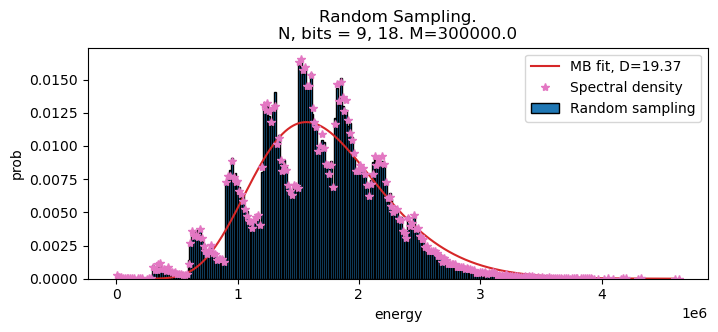

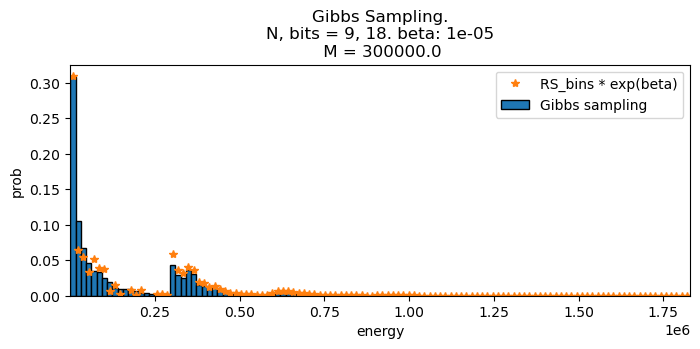

In [4]:
N, P = 9, 2
n_bits = N*P
print(f"N = {N}, P = {P}")
vseed = 45
M = 3e5
Q, const = get_QUBO_NPP(N, P, M, vseed)

# Start sampling data
n_RS_sample = 100_000
n_GS_sample = n_RS_sample
# create RS and Gibbs data
Es_RS = RandomSampler(Q, const, n_bits, n_RS_sample)
Es_SD = SpectralDistribution(Q, const, n_bits)
beta = 1e-5 # 2e-5
Es_GS, states = perf_GibbsSampler(beta, Q, const, n_bits, n_GS_sample)


def combine_SD(Es_SD, bin_width_RS, range):
    bins = int((range[1] - range[0])/bin_width_RS)
    counts, _ = np.histogram(Es_SD.flatten(), range = range, bins = bins)
    density_SD = counts / counts.sum() # normalize to get a probability
    return density_SD



### Random sampling
# get histogram data
bins = 300
fit_lim = None
counts, x_bins = np.histogram(Es_RS.flatten(), bins = bins)
density_RS = counts / counts.sum() # normalize to get a probability
x_pos_RS = (x_bins[1:] + x_bins[:-1])/2
bin_width_RS = x_bins[1]-x_bins[0]
mask = density_RS > 0 # filter out empty bins
density_RS, x_pos_RS = density_RS[mask], x_pos_RS[mask]
# plot RS
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.bar(x_pos_RS, density_RS, width = bin_width_RS, edgecolor='k', linewidth=1, label ="Random sampling")
ax.set_ylabel("prob")
ax.set_xlabel("energy")
plt.title(f"Random Sampling.\nN, bits = {N}, {N*P}. M={M}")
# fit
if fit_lim == None:
    start, end = 0, -2
else:
    start, _ = nearest_to(x_pos_RS, fit_lim[0])
    end, _ = nearest_to(x_pos_RS, fit_lim[1])
XS = np.linspace(x_pos_RS[start], x_pos_RS[end], 1000)
f = lambda x, D, beta, normal : gamma.pdf(x, (D+1)/2, loc = 0, scale = 1/beta) * bin_width_RS * normal
coef_RS, coef_var = sp.optimize.curve_fit(f, x_pos_RS[start:end+1], density_RS[start:end+1], p0 = [5, 1e-7, 1])
coef_std = np.sqrt(np.diag(coef_var))
ax.plot(XS, f(XS, *coef_RS), color = "C3", label = f"MB fit, D={np.round(coef_RS[0], 2)}")
print(f"Dim_RS: {np.round(coef_RS[0], 2)} +- {np.round(coef_std[0], 2)} \t\tbeta_RS: {np.format_float_scientific(coef_RS[1], 1)} +- {np.format_float_scientific(coef_std[1], 1)}")
# plot SpectralDistribution on top of it
density_SD = combine_SD(Es_SD, bin_width_RS, range = (x_bins[0], x_bins[-1]+1))
ax.plot(x_pos_RS, density_SD[mask], "*", color = "C6", label = f"Spectral density")
ax.legend(fontsize = 10, loc='best')
plt.show()






### Gibbs sampling
# get histogram data
bins = int(bins * (np.max(Es_GS) - np.min(Es_GS))/(np.max(Es_RS) - np.min(Es_RS))) # in order to have same bin sizes wrt RS plot 
fit_lim = None
counts, x_bins = np.histogram(Es_GS.flatten(), bins = bins)
density = counts / counts.sum() # normalize to get a probability
x_pos = (x_bins[1:] + x_bins[:-1])/2
bin_width_GS = x_bins[1]-x_bins[0]
mask = density > 0 # filter out empty bins
density, x_pos = density[mask], x_pos[mask]
# plot GS
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.bar(x_pos, density, width = bin_width_GS, edgecolor='k', linewidth=1, label ="Gibbs sampling")
ax.set_ylabel("prob")
ax.set_xlabel("energy")
plt.title(f"Gibbs Sampling.\nN, bits = {N}, {N*P}. beta: {beta}\n M = {M}")
# plot RandomSampling-GibbsEnhanced on top of it
density_RS_enhanced = density_RS * np.exp(-beta*x_pos_RS)
density_RS_enhanced /= np.sum(density_RS_enhanced)
ax.plot(x_pos_RS, density_RS_enhanced, "*", color = "C1", label = f"RS_bins * exp(beta)")
ax.legend(fontsize = 10, loc='best')
ax.set_xlim(np.min(Es_GS), np.max(Es_GS))
plt.show()

### Testing TSP new bounds

N = 7


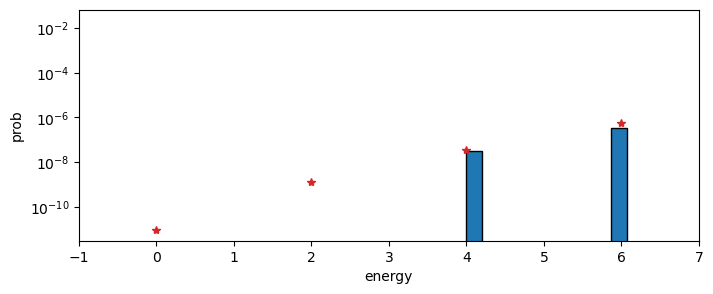

In [ ]:

from scipy.special import factorial, comb
def TSP_viol(N):
    p = np.zeros((8), dtype=np.longdouble)
    for i in range(8):
        match i:
            case 0:
                p[i] = np.longdouble(factorial(N)) # feasible solutions
            case 2:
                p[i] = np.longdouble(factorial(N))*(N+4*comb(N,2)+3/2*comb(N,3))
            case 4:
                p[i] = np.longdouble(factorial(N))*(comb(N,2)+21*comb(N,3)+57*comb(N,4)+45*comb(N,5)+45/4*comb(N,6))
            case 6:
                p[i] = np.longdouble(factorial(N))*5*(47/15*comb(N,3)+24*comb(N,4)+137*comb(N,5)+1157*comb(N,6)+567/4*comb(N,7)+126*comb(N,8)+63/2*comb(N,9))
    return p

## $T_\text{eff}$ estimation via average pseudo-likelihood method

In [133]:

def beta_eff_estimation(Xs, Q, const):
    ''' Given samples, Ising structure, return Beta_eff estimation maximizing the pseudolikelihood'''
    ######## what about the constant of the Ising model? Should we ignore that or incorporate it?

    beta = sp.optimize.minimize_scalar(minus_pseudo_likelihood, bounds = [0, 1e20], args=(Xs, Q, const)) # Alternative to the numerical function: minimize, brute, fminbound
    return beta

def minus_pseudo_likelihood(beta, Xs, Q, const):
    D, N = np.shape(Xs)
    Gamma_samples = np.ndarray((D), dtype = np.float128)
    for d in range(D):
        #Gamma_samples[d] = np.mean( [np.log( 1 + np.exp( -2*np.float128(beta)* (Xs[d, i]*np.sum(Q[i]*Xs[d]) + const) ) ) for i in range(N)] )
        Gamma_samples[d] = np.mean( [np.log( 1 + np.exp( -2*np.float128(beta)* (Xs[d, i]*np.sum(Q[i]*Xs[d]) ) ) ) for i in range(N)] )
        #print(np.mean( [np.float128(np.log( np.float128(1) + np.float128(np.exp( -np.float128(2)*np.float128(beta)* (np.float128(Xs[d, i])*np.sum(np.float128(Q[i])*np.float128(Xs[d])) + np.float128(const)))))) for i in range(N)] ))
    return np.mean(Gamma_samples)


N = 9, P = 2


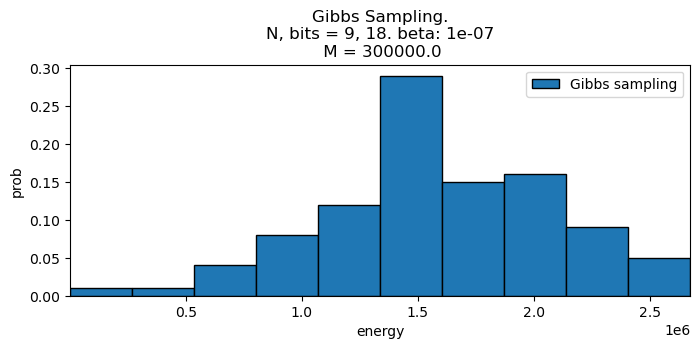



0.6931640386453823593


0.693315796538648247


0.6948368527597840652


0.7016735828292913112


0.71039493973654527594


0.72842036214368620806


0.8988960913096546628


/tmp/ipykernel_46687/2114768180.py:13: RuntimeWarning: overflow encountered in exp
  Gamma_samples[d] = np.mean( [np.log( 1 + np.exp( -2*np.float128(beta)* (Xs[d, i]*np.sum(Q[i]*Xs[d]) ) ) ) for i in range(N)] )
/home/edo/anaconda3/envs/qubo_env/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2288: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/home/edo/anaconda3/envs/qubo_env/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2289: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)


 message: Solution found.
 success: True
  status: 0
     fun: inf
       x: 9.999999848790775e+19
     nit: 37
    nfev: 37


In [134]:
# Test it

N, P = 9, 2
n_bits = N*P
print(f"N = {N}, P = {P}")
vseed = 45
M = 3e5
Q, const = get_QUBO_NPP(N, P, M, vseed)

# Start sampling data
n_sample = 100
beta = 1e-7 # 2e-5
Es_GS, states = perf_GibbsSampler(beta, Q, const, n_bits, n_sample)

### Gibbs sampling
# get histogram data
bins = "auto"
fit_lim = None
counts, x_bins = np.histogram(Es_GS.flatten(), bins = bins)
density = counts / counts.sum() # normalize to get a probability
x_pos = (x_bins[1:] + x_bins[:-1])/2
bin_width_GS = x_bins[1]-x_bins[0]
mask = density > 0 # filter out empty bins
density, x_pos = density[mask], x_pos[mask]
# plot GS
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.bar(x_pos, density, width = bin_width_GS, edgecolor='k', linewidth=1, label ="Gibbs sampling")
ax.set_ylabel("prob")
ax.set_xlabel("energy")
ax.set_title(f"Gibbs Sampling.\nN, bits = {N}, {N*P}. beta: {beta}\n M = {M}")
ax.legend(fontsize = 10, loc='best')
ax.set_xlim(np.min(Es_GS), np.max(Es_GS))
plt.show()


for beta_i in [beta/1000, beta/100, beta/10, beta/2, beta, 2*beta, 10*beta]:
    print("\n")
    print(minus_pseudo_likelihood(beta_i, states, Q, const))
###### It doesn't seem to be a minimum at the true Beta? Maybe because true beta is not the beta given as input, but that modified by the instance?


beta_eff = beta_eff_estimation(states, Q, const)
print(beta_eff)

## M method application to single Gibbs instance

Implement method to choose penalty factor $M$.
Assumptions:
- Sampling is according to Gibbs factor (perfect Gibbs sampling). Generally, it differs from annealing sampling, since it doesn't suffer from local minima traps.
- A post-processing bit-swap local search is performed (this assumption may be dropped, but the math of the final formulation may get more involved). So it's actually perfect Gibbs followed by bit-swap.
- Estimation of the number of feasible solutions is given. Also, the number of infeasible solutions violating the constraints by $k = 1,2,\dots, k_{max}$ (e.g. $k_{max} = 4$) is given. In other words, the first infeasibilty peaks of $H_{pen}$ have been identified, either analytically or numerically.

TODO: show and explain final formula of the method

In [5]:
# Gibbs sampling with bit-swap

def state_inttobin(i, n):
    state_string = bin(i)[2:].zfill(n)
    return [int(b) for b in state_string]

def state_bintoint(b):
    b_numb = ''.join([str(k) for k in b])
    return int(b_numb, 2)

def perf_GibbsSampler_bitswap(beta, Q, const, nbits, n_samples):
    probs, ener = compute_Gibbs_probs(beta, Q, const)
    return sample_Gibbs_bitswap(probs, ener, n_samples, nbits)

def sample_Gibbs_bitswap(probs, eners, n_samples, nbits):
    states_sampled_int = np.random.choice(np.arange(2**(nbits)), p = probs, size = n_samples)
    for i in range(n_samples):
        states_sampled_int[i] = bitswap(states_sampled_int[i], eners, nbits)
    states_sampled_bin = [state_inttobin(x, nbits) for x in states_sampled_int]
    return eners[states_sampled_int], states_sampled_bin

def bitswap(state_int, eners, nbits):
    '''Performs bit-swap search: for all hamming distance 1 neighbours of the given state, returns the best one in terms of energy'''
    neighs_int = neighbours(state_int, nbits)
    eners_neigh = eners[neighs_int]
    if np.min(eners_neigh) < eners[state_int]:
        return neighs_int[ np.where(eners_neigh == np.min(eners_neigh))[0][0] ]
    return state_int

def neighbours(state_int, nbits):
    state_bin = state_inttobin(state_int, nbits)
    neighs_int = np.ndarray((nbits), dtype = int)
    for i in range(nbits):
        neigh_bin = deepcopy(state_bin)
        neigh_bin[i] = 1 - neigh_bin[i]
        neighs_int[i] = state_bintoint(neigh_bin)
    return neighs_int


# Gibbs sampling

def perf_GibbsSampler(beta, Q, const, nbits, n_samples):
    probs, ener = compute_Gibbs_probs(beta, Q, const)
    return sample_Gibbs(probs, ener, n_samples, nbits)

def sample_Gibbs(probs, eners, n_samples, nbits):
    states_sampled_int = np.random.choice(np.arange(2**(nbits)), p = probs, size = n_samples)
    eners_sampled = eners[states_sampled_int]
    states_sampled_bin = [state_inttobin(x, nbits) for x in states_sampled_int]
    return eners_sampled, states_sampled_bin


#### post-check

def count_feasibility_optimality(states, Q_pen, const_pen, Es, E_f):
    cnt_feas,cnt_opt = 0, 0
    for i_state, state in enumerate(states):
        if np.isclose(evaluate_energy(state, Q_pen, const_pen), 0):
            cnt_feas += 1
            if Es[i_state] <= E_f:
                cnt_opt += 1
    return cnt_feas/len(states), cnt_opt/len(states)

NPP problem, size:  N = 9, P = 2

Sampling prob. feasible = 0.4902  >= feasible and energy in [0 , E_f=30000000.0] = 0.4902. Guarantee = 0.5
M_l1 in hot environment for this instance: 1.37e+09


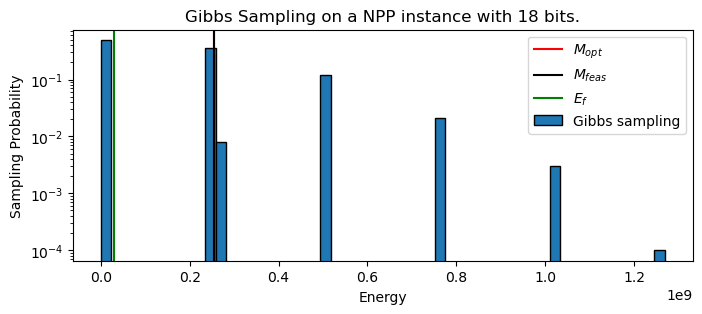

In [22]:
### Test M method (create problem, apply technique, simulate Gibbs sampling and plot)
from myalgo import M_method_opt, M_method_feas

# 1. set problem 
problem_type = "NPP"
if problem_type == "NPP":
    N, P = 9, 2
    n_bits = N*P
    size = (N, P)
    print(f"NPP problem, size:  N = {N}, P = {P}")
elif problem_type == "TSP":
    N_cities = 4
    n_bits = N_cities**2
    size = N_cities
    print(f"TSP problem, size:  N_citites = {N_cities}")
vseed = 43
circle_flag = False # for TSP: os True, the instances are generated on a circle like Fujitsu did, else, the cities are randomly placed

# 2. set parameters: temperature, min_probabilty, max_energy and vioaltion_peaks
beta = 1e-8
peak_max = 4
min_pfeas = 0.5 # eta
E_f = 3e7

# 3. apply method to find penalty M
E_LB = 0
M, eta_guaran = M_method_opt(size, problem_type, vseed, "seed", beta, peak_max, min_pfeas, E_f, E_LB, circle_flag)
#M_badtail, eta_guaran_badtail = M_method_badtail(size, problem_type, vseed, "seed", beta, peak_max, min_pfeas, E_f, E_LB, circle_flag)
M_feas, eta_guaran_feas = M_method_feas(size, problem_type, vseed, "seed", beta, peak_max, min_pfeas, E_LB, circle_flag)

M, M_feas = M.astype(float), M_feas.astype(float)

# 4. build QUBO with M and sample from it with Gibbs
n_sample = 10_000
M_QUBO = M
if problem_type == "NPP":
    Q, const = get_QUBO_NPP(N, P, M_QUBO, vseed)
    Q_pen, const_pen = get_QUBO_NPP(N, P, M_QUBO, vseed, objective=False)
elif problem_type == "TSP":
    Q, const = get_QUBO_TSP(N_cities, M_QUBO, vseed, circle_flag = False)
    Q_pen, const_pen = get_QUBO_TSP(N_cities, M_QUBO, vseed, objective=False)

Es, states = perf_GibbsSampler(beta, Q, const, n_bits, n_sample)
# measure sampling quality (feasibility and optimality)
feas_prob, opt_prob = count_feasibility_optimality(states, Q_pen, const_pen, Es, E_f)
print(f"\nSampling prob. feasible = {feas_prob}  >= feasible and energy in [0 , E_f={E_f}] = {opt_prob}. Guarantee = {eta_guaran}")

### M_l1 (beta)
Q_obj, const_obj = get_QUBO_NPP(N, P, 0, vseed, penalization = False)
M_L1_hot = L1_norm_hot(Q_obj, const_obj, N*P, 1/beta, max_prob_inf = min_pfeas)
print(f"M_l1 in hot environment for this instance: {np.format_float_scientific(M_L1_hot, 2)}")

# 5. plot and check prob_feas for Gibbs and bit-swap
# get histogram data
bins = "auto"
counts, x_bins = np.histogram(Es.flatten(), bins = bins)
density = counts / counts.sum() # normalize to get a probability
x_pos = (x_bins[1:] + x_bins[:-1])/2
bin_width = x_bins[1]-x_bins[0]
mask = density > 0 # filter out empty bins
density, x_pos = density[mask], x_pos[mask]
# plot
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.bar(x_pos, density, width = bin_width, edgecolor='k', linewidth=1, label ="Gibbs sampling")
ax.set_ylabel("Sampling Probability")
ax.set_xlabel("Energy")
plt.title(f"Gibbs Sampling on a {problem_type} instance with {n_bits} bits.")
ax.axvline(M, color = "r", label = r"$M_{opt}$")
ax.axvline(M_feas, color = "k", label = r"$M_{feas}$")
#ax.axvline(M_L1_hot, color = "k")
ax.set_yscale("log")
ax.axvline(E_f, color = "g", label = r"$E_f$")
#ax.set_xscale("log")
ax.legend(fontsize = 10, loc='best')
plt.show()

#fig.savefig("Gibbs")

## $M$ and $\eta$ guaranteed dependence on $E_f$ and 

In [8]:
### Test M method at varying E_f. Also, minimum probability guaranteed as a fct of E_f
#from myalgo import M_method

# 1. set problem 
problem_type = "NPP"
if problem_type == "NPP":
    N, P = 9, 2
    size = (N, P)
    print(f"NPP problem, size:  N = {N}, P = {P}")
elif problem_type == "TSP":
    N_cities = 4
    size = N_cities
    print(f"TSP problem, size:  N_citites = {N_cities}")
vseed = 42
circle_flag = False # for TSP: os True, the instances are generated on a circle like Fujitsu did, else, the cities are randomly placed


# 2. set parameters: temperature, min_probabilty, max_energy and vioaltion_peaks
beta = 1e-5
peak_max = 4
min_pfeas = 0.5 # eta
E_LB = 0


Efs = np.logspace(3, 6, 40)
Ms_toplot, eta_guarantes = np.ndarray((len(Efs))), np.ndarray((len(Efs)))

# 3. apply method to find penalty M
for i, E_f in enumerate(tqdm.tqdm(Efs)):
    Ms_toplot[i], eta_guarantes[i] = M_method_opt(size, problem_type, vseed, "seed", beta, peak_max, min_pfeas, E_f, E_LB, circle_flag)

valid = np.isclose(eta_guarantes, min_pfeas) 

NPP problem, size:  N = 9, P = 2


  2%|▎         | 1/40 [00:00<00:13,  2.99it/s]

With tolerance 0.5, poly root doesn't exist. Feasibility tolerance decreased to 0.04918359403536242


  5%|▌         | 2/40 [00:00<00:12,  2.94it/s]

With tolerance 0.5, poly root doesn't exist. Feasibility tolerance decreased to 0.07249648985449882


  8%|▊         | 3/40 [00:01<00:12,  2.93it/s]

With tolerance 0.5, poly root doesn't exist. Feasibility tolerance decreased to 0.07000083760948686


 10%|█         | 4/40 [00:01<00:12,  2.84it/s]

With tolerance 0.5, poly root doesn't exist. Feasibility tolerance decreased to 0.1269514338814654


 12%|█▎        | 5/40 [00:01<00:12,  2.79it/s]

With tolerance 0.5, poly root doesn't exist. Feasibility tolerance decreased to 0.11148133604294379


 15%|█▌        | 6/40 [00:02<00:12,  2.83it/s]

With tolerance 0.5, poly root doesn't exist. Feasibility tolerance decreased to 0.1479123666780047


 18%|█▊        | 7/40 [00:02<00:11,  2.76it/s]

With tolerance 0.5, poly root doesn't exist. Feasibility tolerance decreased to 0.14210365021331955


 20%|██        | 8/40 [00:02<00:11,  2.73it/s]

With tolerance 0.5, poly root doesn't exist. Feasibility tolerance decreased to 0.16812124181473106


 22%|██▎       | 9/40 [00:03<00:11,  2.69it/s]

With tolerance 0.5, poly root doesn't exist. Feasibility tolerance decreased to 0.18206021045357249


 25%|██▌       | 10/40 [00:03<00:11,  2.69it/s]

With tolerance 0.5, poly root doesn't exist. Feasibility tolerance decreased to 0.19439329313186646


 28%|██▊       | 11/40 [00:03<00:10,  2.71it/s]

With tolerance 0.5, poly root doesn't exist. Feasibility tolerance decreased to 0.22529209709616016


 30%|███       | 12/40 [00:04<00:10,  2.76it/s]

With tolerance 0.5, poly root doesn't exist. Feasibility tolerance decreased to 0.2542627441996847


 32%|███▎      | 13/40 [00:04<00:09,  2.75it/s]

With tolerance 0.5, poly root doesn't exist. Feasibility tolerance decreased to 0.2734288373272109


 35%|███▌      | 14/40 [00:05<00:09,  2.77it/s]

With tolerance 0.5, poly root doesn't exist. Feasibility tolerance decreased to 0.3320310301210594


 38%|███▊      | 15/40 [00:05<00:08,  2.78it/s]

With tolerance 0.5, poly root doesn't exist. Feasibility tolerance decreased to 0.36075771745167173


 40%|████      | 16/40 [00:05<00:08,  2.73it/s]

With tolerance 0.5, poly root doesn't exist. Feasibility tolerance decreased to 0.40457966383840277


 42%|████▎     | 17/40 [00:06<00:08,  2.71it/s]

With tolerance 0.5, poly root doesn't exist. Feasibility tolerance decreased to 0.4598244525131532


 45%|████▌     | 18/40 [00:06<00:08,  2.72it/s]

With tolerance 0.5, poly root doesn't exist. Feasibility tolerance decreased to 0.47619720617986555


100%|██████████| 40/40 [00:14<00:00,  2.69it/s]


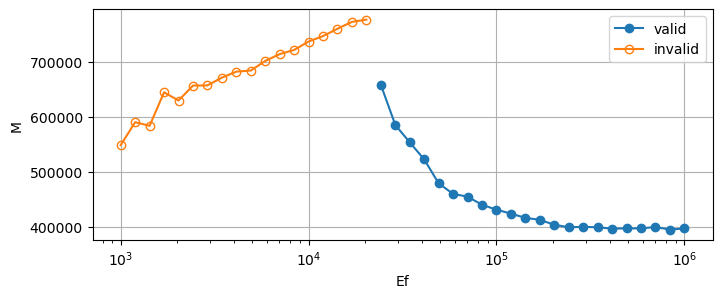

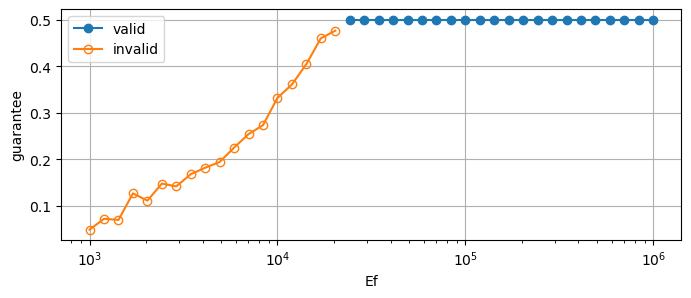

In [9]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.plot(Efs[valid], Ms_toplot[valid], "-o", label = "valid")
ax.plot(Efs[np.logical_not(valid)], Ms_toplot[np.logical_not(valid)], "-o", fillstyle='none', label = "invalid")
ax.set_ylabel("M")
ax.set_xlabel("Ef")
ax.set_xscale("log")
#ax.set_yscale("log")
ax.legend(fontsize = 10, loc='best')
ax.grid()
plt.show()

fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.plot(Efs[valid], eta_guarantes[valid], "-o", label = "valid")
ax.plot(Efs[np.logical_not(valid)], eta_guarantes[np.logical_not(valid)], "-o", fillstyle='none', label = "invalid")
ax.set_ylabel("guarantee")
ax.set_xlabel("Ef")
ax.set_xscale("log")
#ax.set_yscale("log")
ax.legend(fontsize = 10, loc='best')
ax.grid()
plt.show()

## $\eta$ required vs $\eta$ effective  ---  optimality strategy

In [10]:
# 1. set problem 
problem_type = "NPP"
P = 2
vseed = 42


# 2. set parameters
beta = 1e-5
peak_max = 4
min_pfeas = 0.5 # eta
E_LB = 0


Ns = np.array([7, 8, 9])
betas = np.array([1e-5, 5e-6, 2e-6, 1e-6,])
etas_required = np.array([.35, .4, .45, .5, .55, .6, .65])
E_f = 1e6

etas_guaranteed = np.ndarray((len(Ns), len(betas), len(etas_required)))
etas_effective = np.ndarray((len(Ns), len(betas), len(etas_required)))

for N_idx, N in enumerate(tqdm.tqdm(Ns)):
    n_bits = N*P
    size = (N, P)

    for beta_idx, beta in enumerate(betas):

        for eta_idx, eta_req in enumerate(etas_required):
            # run method with parameters and collect eta guaranteed
            M, etas_guaranteed[N_idx, beta_idx, eta_idx] = M_method_opt(size, problem_type, vseed, "seed", beta, peak_max, eta_req, E_f, E_LB)
            M = M.astype(float)

            # run gibbs sampling and
            n_sample = 1000
            Q, const = get_QUBO_NPP(N, P, M, vseed)
            Q_pen, const_pen = get_QUBO_NPP(N, P, M, vseed, objective=False)
            Es, states = perf_GibbsSampler(beta, Q, const, n_bits, n_sample)

            # collect eta effective
            feas_prob, opt_prob = count_feasibility_optimality(states, Q_pen, const_pen, Es, E_f)
            etas_effective[N_idx, beta_idx, eta_idx] = opt_prob


100%|██████████| 3/3 [01:12<00:00, 24.23s/it]


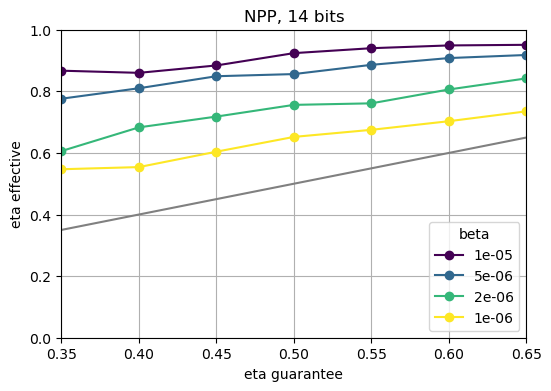

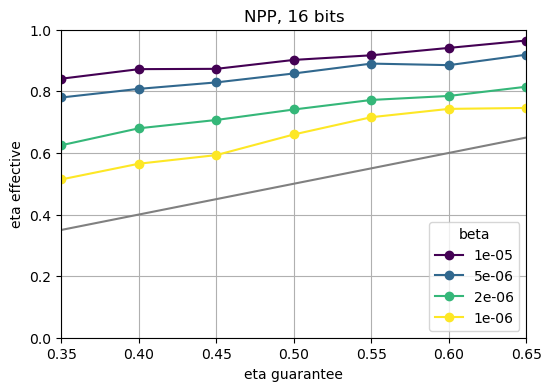

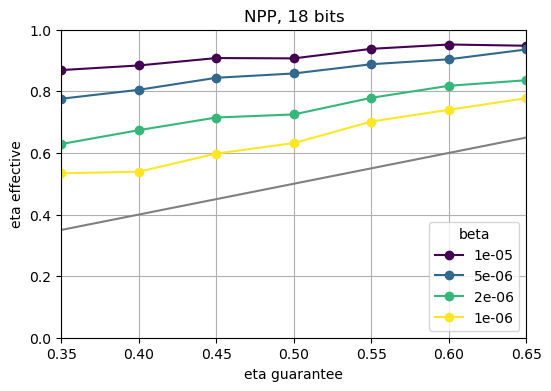

In [11]:
# plot

from matplotlib.colors import ListedColormap
colormap = plt.cm.viridis.reversed()
discr_colors = ListedColormap(colormap(np.linspace(0, 1, len(betas)))).reversed()

for N_idx, N in enumerate(Ns):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    for beta_idx, beta in enumerate(betas):
        req_satisf = np.isclose(etas_guaranteed[N_idx, beta_idx], etas_required) # mask to differentiate where the guarantee is the required one (True), or the guarantee had to be decreased (False)
        ax.plot(etas_required[req_satisf], etas_effective[N_idx, beta_idx][req_satisf], "-o", color = discr_colors.colors[beta_idx], label = f"{beta}")
        ax.plot(etas_guaranteed[N_idx, beta_idx][np.logical_not(req_satisf)], etas_effective[N_idx, beta_idx][np.logical_not(req_satisf)], "-o", color = discr_colors.colors[beta_idx], fillstyle='none')
    ax.set_ylabel("eta effective")
    ax.set_xlabel("eta guarantee")
    ax.set_title(f"NPP, {N*P} bits")
    ax.plot(etas_required, etas_required, color = "gray")
    ax.legend(fontsize = 10, loc='best', title = "beta")
    ax.set_xlim(np.min(etas_required), np.max(etas_required))
    ax.set_ylim(0, 1)
    ax.grid()
    plt.show()

## $\eta$ required vs $\eta$ effective  ---  feasibility strategy

In [12]:
# 1. set problem 
problem_type = "NPP"
P = 2
vseed = 42


# 2. set parameters
beta = 1e-5
peak_max = 4
min_pfeas = 0.5 # eta
E_LB = 0


Ns = np.array([7, 8, 9])
betas = np.array([1e-5, 5e-6, 2e-6, 1e-6,])
etas_required = np.array([.35, .4, .45, .5, .55, .6, .65])

betas = np.array([1e-5, 1e-6, 1e-7])
etas_required = np.array([.1, .3, .5, .7, .9])

etas_guaranteed = np.ndarray((len(Ns), len(betas), len(etas_required)))
etas_effective = np.ndarray((len(Ns), len(betas), len(etas_required)))

for N_idx, N in enumerate(tqdm.tqdm(Ns)):
    n_bits = N*P
    size = (N, P)

    for beta_idx, beta in enumerate(betas):

        for eta_idx, eta_req in enumerate(etas_required):
            # run method with parameters and collect eta guaranteed
            M, etas_guaranteed[N_idx, beta_idx, eta_idx] = M_method_feas(size, problem_type, vseed, "seed", beta, peak_max, eta_req, E_LB)
            M = M.astype(float)

            # run gibbs sampling and
            n_sample = 1000
            Q, const = get_QUBO_NPP(N, P, M, vseed)
            Q_pen, const_pen = get_QUBO_NPP(N, P, M, vseed, objective=False)
            Es, states = perf_GibbsSampler(beta, Q, const, n_bits, n_sample)

            # collect eta effective
            feas_prob, opt_prob = count_feasibility_optimality(states, Q_pen, const_pen, Es, E_f = np.max(Es))
            etas_effective[N_idx, beta_idx, eta_idx] = feas_prob

100%|██████████| 3/3 [00:37<00:00, 12.64s/it]


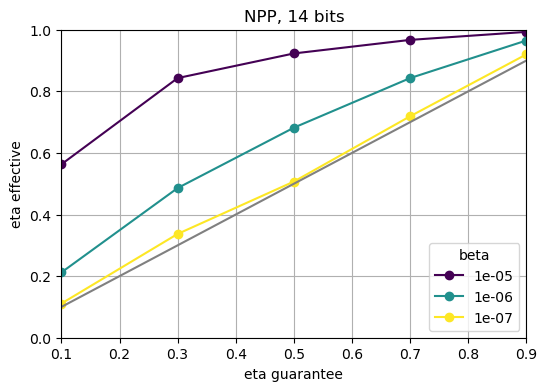

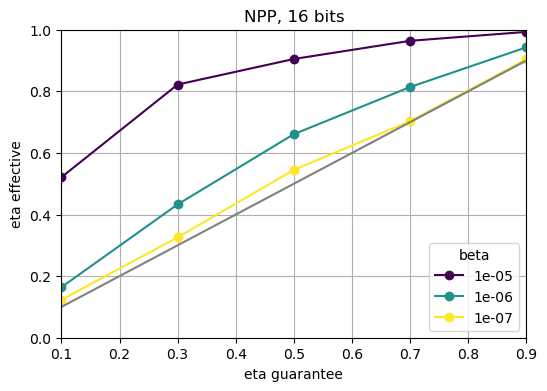

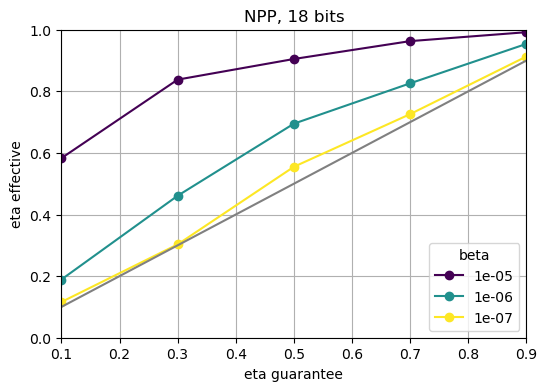

In [13]:
# plot

from matplotlib.colors import ListedColormap
colormap = plt.cm.viridis.reversed()
discr_colors = ListedColormap(colormap(np.linspace(0, 1, len(betas)))).reversed()

for N_idx, N in enumerate(Ns):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    for beta_idx, beta in enumerate(betas):
        req_satisf = np.isclose(etas_guaranteed[N_idx, beta_idx], etas_required) # mask to differentiate where the guarantee is the required one (True), or the guarantee had to be decreased (False)
        ax.plot(etas_required[req_satisf], etas_effective[N_idx, beta_idx][req_satisf], "-o", color = discr_colors.colors[beta_idx], label = f"{beta}")
        ax.plot(etas_guaranteed[N_idx, beta_idx][np.logical_not(req_satisf)], etas_effective[N_idx, beta_idx][np.logical_not(req_satisf)], "-o", color = discr_colors.colors[beta_idx], fillstyle='none')
    ax.set_ylabel("eta effective")
    ax.set_xlabel("eta guarantee")
    ax.set_title(f"NPP, {N*P} bits")
    ax.plot(etas_required, etas_required, color = "gray")
    ax.legend(fontsize = 10, loc='best', title = "beta")
    ax.set_xlim(np.min(etas_required), np.max(etas_required))
    ax.set_ylim(0, 1)
    ax.grid()
    plt.show()

## Old codes on other tests

#### Varying max_peak

In [ ]:
# ### Test M method (create problem, apply technique, simulate Gibbs sampling and plot)

# # 1. set problem 
# problem_type = "TSP"
# if problem_type == "NPP":
#     N, P = 9, 2
#     n_bits = N*P
#     size = (N, P)
#     print(f"NPP problem, size:  N = {N}, P = {P}")
# elif problem_type == "TSP":
#     N_cities = 4
#     n_bits = N_cities**2
#     size = N_cities
#     print(f"TSP problem, size:  N_citites = {N_cities}")
# vseed = 45


# # 2. set parameters: temperature, min_probabilty, max_energy and vioaltion_peaks
# beta = 1e-5
# min_pfeas = 0.5 # eta
# E_f = 1e7


# # 3. apply method to find penalty M
# E_LB = 0
# max_peaks_tested = np.arange(1, 5)
# feas_probs, opt_probs = np.ndarray((len(max_peaks_tested))), np.ndarray((len(max_peaks_tested)))
# for idx_peak, peak_max in enumerate(max_peaks_tested):
#     M = M_method_opt(size, problem_type, vseed, beta, peak_max, min_pfeas, E_f, E_LB)

#     # 4. build QUBO with M and sample from it with Gibbs
#     n_sample = 100_000
#     if problem_type == "NPP":
#         Q, const = get_QUBO_NPP(N, P, M, vseed)
#         Q_pen, const_pen = get_QUBO_NPP(N, P, M, vseed, objective=False)
#     elif problem_type == "TSP":
#         Q, const = get_QUBO_TSP(N_cities, M, vseed, circle_flag = False)
#         Q_pen, const_pen = get_QUBO_TSP(N_cities, M, vseed, objective=False)

#     Es, states = perf_GibbsSampler(beta, Q, const, n_bits, n_sample)
#     # measure sampling quality (feasibility and optimality)
#     feas_probs[idx_peak], opt_probs[idx_peak] = count_feasibility_optimality(states, Q_pen, const_pen, Es, E_f)
#     print(f"Feasib. sampling prob is {feas_probs[idx_peak]}  >=  Feasible points ratio in [0 , E_f={E_f}] is {opt_probs[idx_peak]}")


# # 5. plot
# # plot
# fig = plt.figure(figsize=(8, 5))
# ax = fig.add_subplot(111)
# ax.plot(max_peaks_tested, feas_probs, "o", color = "C0", label = "feasible prob")
# ax.plot(max_peaks_tested, opt_probs, "o", color = "C1", label = "[feasible and E<Ef] prob")
# ax.set_ylabel("prob feaasible")
# ax.set_xlabel("max peak")
# plt.title(f"feasibility sampling probability, {problem_type} instance, bits = {n_bits}.\n beta: {beta}")
# ax.axhline(min_pfeas, color = "k", label = "min prob required")
# #ax.set_yscale("log")
# ax.legend(fontsize = 10, loc='best')
# plt.grid()
# plt.show()


#### Plot $n_{pen}(v)$ for all problem, sto see if there's super exponential growth

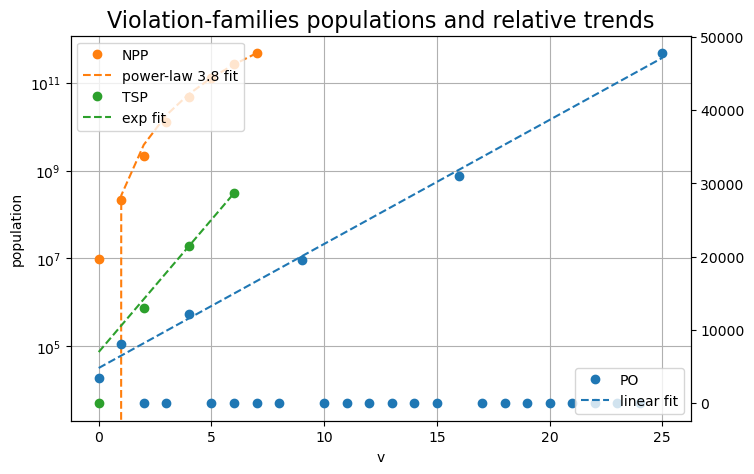

In [ ]:
from myalgo import p_viols_exact_PO, p_viols_exact_TSP, p_viols_exact_NPP

Npo, w, vmax_po = 8, 3, 25
Nc, vmax_tsp = 7, 7
Nnpp, P, vmax_npp = 10, 5, 7

n_po = p_viols_exact_PO(Npo, w, vmax_po) * 2**(Npo * w)
n_npp = p_viols_exact_NPP(Nnpp, P, vmax_npp) * 2**(Nnpp * P)
n_tsp = p_viols_exact_TSP(Nc, vmax_tsp) * 2**(Nc**2)
# Note: to avoid the feasible point in the fit, set start=1. if you want to include, set start=0
start = 0
x_po = np.arange(len(n_po))[n_po != 0][start:]
x_npp = np.arange(len(n_npp))[n_npp != 0][start:]
x_tsp = np.arange(len(n_tsp))[n_tsp != 0][start:]


#f_exp = lambda x, a, b : b*np.exp(a*x)
f_lin = lambda x, m, q : m*x + q
f_pow = lambda x, a, b : a*x**b
f_exp = lambda x, a, b: a*np.exp(x*b)
coef_npp, coef_var_npp = sp.optimize.curve_fit(f_pow, x_npp, n_npp[x_npp], p0=[1, 3])
coef_po, coef_var_po = sp.optimize.curve_fit(f_lin, x_po, n_po[x_po])
coef_tsp, coef_var_tsp = sp.optimize.curve_fit(f_pow, x_tsp, n_tsp[x_tsp])
coef_tsp_exp, coef_var_tsp_exp = sp.optimize.curve_fit(f_exp,x_tsp, n_tsp[x_tsp])

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax2.plot(np.arange(len(n_po)), n_po, "o", color = "C0", label = "PO")
ax2.plot(x_po, f_lin(x_po, *coef_po), "--", color = "C0", label = "linear fit")
ax.plot(np.arange(len(n_npp)), n_npp, "o", color = "C1", label = "NPP")
ax.plot(x_npp, f_pow(x_npp, *coef_npp), "--", color = "C1", label = f"power-law {np.round(coef_npp[1], 1)} fit")
ax.plot(np.arange(len(n_tsp)), n_tsp, "o", color = "C2", label = "TSP")
ax.plot(x_tsp, f_exp(x_tsp, *coef_tsp_exp), "--", color = "C2", label = "exp fit")
# ax.plot(x_tsp, f_pow(x_tsp, *coef_tsp), "--", color = "C2", label = "pow fit")
ax.set_title("Violation-families populations and relative trends", fontsize = 16)
ax.set_ylabel("population")
ax.set_xlabel("v")
ax.set_yscale("log")
#ax.set_xscale("log")
ax.legend(fontsize = 10, loc='upper left')
ax2.legend(fontsize = 10, loc='lower right')
ax.grid()
plt.show()


#### testing the single bounds

In [ ]:
### Cumulative tests (testing Pf lower bound)

def cumulative_NPP(E_f, beta, N, P, seed, n_samples = 10_000):

    eners = RandomSampler_Feasible_NPP(N, P, seed, n_samples)

    # cumul-unique
    crude_cumul = np.sum(eners <= E_f)/len(eners)
    # cumul-divided
    n_chunks = 100
    E_LB = 0
    delta = (E_f - E_LB) / n_chunks
    cum_exp = np.sum([ np.exp(- beta * (E_LB + (j+1)*delta) ) * np.sum( np.logical_and(eners >= E_LB + j*delta, eners <= E_LB + (j+1)*delta) )/ len(eners) for j in np.arange(n_chunks) ])

    for n_chunks in [1, 10, 1e2, 1e3, 1e4]:
        delta = (E_f - E_LB) / n_chunks
        cum_exp_tests = np.sum([ np.exp(- beta * (E_LB + (j+1)*delta) ) * np.sum( np.logical_and(eners >= E_LB + j*delta, eners <= E_LB + (j+1)*delta) )/ len(eners) for j in np.arange(n_chunks) ])
        print(f"With {int(n_chunks)} chunks the integral is {cum_exp_tests}")
    
    # compute comulative by fitting
    bins = 100
    counts, x_bins = np.histogram(eners.flatten(), bins = bins)
    density = counts / counts.sum() # normalize to get a probability
    x_pos = (x_bins[1:] + x_bins[:-1])/2
    bin_width = x_bins[1]-x_bins[0]
    mask = density > 0 # filter out empty bins
    density, x_pos = density[mask], x_pos[mask]

    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(111)
    ax.bar(x_pos, density, width = bin_width, edgecolor='k', linewidth=1, label ="Random sampling")
    ax.axvline(E_f, color = "r")
    plt.show()

    print(f"Crude_cum_exp= {crude_cumul*np.exp(-beta*E_f)}\nCum_exp_divided= {cum_exp}")
    #cum_divided_test = np.sum([ np.sum( np.logical_and(eners >= E_LB + j*delta, eners <= E_LB + (j+1)*delta) )/ len(eners) for j in np.arange(n_chunks) ])
    #print(f"Crude cumul= {crude_cumul}\nCum__divided= {cum_divided_test}")
    
    # XS = np.linspace(x_pos[0], x_pos[-1], 1000)
    # f = lambda x, D, beta, normal : gamma.pdf(x, (D+1)/2, loc = 0, scale = 1/beta) * bin_width * normal
    # ax.plot(XS, f(XS, *[.5, 2e-7, 1]), color = "C1")
    # coef, coef_var = sp.optimize.curve_fit(f, x_pos, density, p0 = [.5, 2e-7, 1])    
    # ax.plot(XS, f(XS, *coef), color = "C3", label = f"MB fit, D={np.round(coef[0], 2)}")
    return crude_cumul


N, P = 10, 4
E_f = 3e5
beta = 1e-3
seed = 45
cumul = cumulative_NPP(E_f, beta, N, P, seed)
